# An introduction to the `sequence-jacobian` toolkit

## NOTE: This notebook is outdated with the development of the new `sequence-jacobian` API. Please refer to the other notebooks as of now.

This notebook serves as an introduction to the `sequence-jacobian` toolkit and the classes and main functions it provides for solving dynamic general equilibrium models in sequence space.

This introduction will cover the following topics:
0. `sequence-jacobian` preliminaries
    - The `sequence-jacobian` toolkit directory structure
    - Importing `sequence-jacobian`
1. How do `Block` objects work?
    1. `SimpleBlock`
    2. `HetBlock`
    3. `SolvedBlock`
2. The primary functions of `sequence-jacobian`
    - `steady_state`
    - `get_G`
    - `td_solve`

The notebook accompanies the working paper by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

Also, this notebook borrows material from the other model example notebooks so be sure to check out them out to see a more complete model solution workflow using `sequence-jacobian`.

# `sequence-jacobian` preliminaries

##  0.1 The `sequence-jacobian' directory structure 

We will only illustrate a smaller subset of the directory structure for the sake of clarity.

```
sequence-jacobian/
│
├──notebooks/
│  ├─ intro_to_sequence_jacobian.ipynb
│  └─ rbc.ipynb
│  
└──sequence_jacobian/
   ├─ blocks/
   │    ├─ simple
   │    ├─ het
   │    ├─ helper
   │    └─ solved
   │
   ├─ models/
   │    ├─ rbc
   │    ├─ krusell_smith
   │    └─ hank
   │
   ├─ utilities/
   │    ├─ discretize
   │    ├─ graph
   │    └─ devtools
   │
   ├─ jacobian
   ├─ nonlinear
   └─ steady_state
```

The `sequence-jacobian` repository contains a few directories at the top-level.

The notable ones for the purposes of this introduction are:
- `notebooks`: where example notebooks demonstrate the `sequence-jacobian` functionality on well-known models
- `sequence_jacobian`: the main python package containing the source code.

Within `sequence_jacobian`, we have:
- Modules implementing the main steps of the solution method: `jacobian`, `nonlinear`, `steady_state`
- Sub-directories containing:
    - `blocks`: definitions of the various `Block` objects, which wrap model equations
    - `models`: implemented models as collections of `Block` objects
    - `utilities`: useful functions that support user in debugging their code and that improve workflow within the `sequence-jacobian` source code

##  0.2 Importing the `sequence-jacobian` code

There are a few different routes to importing the `sequence_jacobian` package properly. Depending on your desired environment or what you find convenient, make sure you follow one of these procedures first, or else the `sequence_jacobian` package will not load properly for you:

1. **(Recommended) Using `pip`**: You can install `sequence-jacobian` using `pip`, python's native package-management system, by executing the following command in your python console with `pip` loaded: `pip install git+https://github.com/shade-econ/sequence-jacobian@develop-cai`. Alternatively you can append `python -m ` to the front of that command and execute it directly in the terminal.
2. **Using sys.path.append()**: You can directly clone the `sequence-jacobian` repository from Github [here](https://github.com/shade-econ/sequence-jacobian/tree/develop-cai), import the `sys` package inside your python console, and call `sys.path.append(<the/path/to/sequence_jacobian>)`. E.g. if you want to run this notebook, you can call `sys.path.append(..)`.
3. **Using `conda`**: While `conda` does not have a straightforward way of building from source like `pip`, if you prefer to work within `conda` environments, you can create a `conda` environment and then use `pip` as above to install `sequence-jacobian` within your `conda` environment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import simple, het, solved, steady_state, get_G, td_solve
from sequence_jacobian import utilities as utils

# 1 How do `Block` objects work?

The first step of solving a model is to come up with a "Directed Acyclic Graph" (**DAG**) representation for it and specify its building `Block`s.

`Block` objects are collections of the model's equilibrium conditions, typically grouped as the conceptual pieces of the model, e.g. firm problem, household problem, market clearing conditions. Each `Block` takes a set of parameters and variables as inputs and produces another set as outputs.

A model's equilibrium conditions and associated unknown variables can be re-written as a directed acyclic graph (DAG) of `Block`s, whose structure can be exploited for fast computing the model's steady state and solving for linear and non-linear dynamic responses of endogenous variables to shocks.

## 1.A `SimpleBlock`

The simplest python class that `sequence-jacobian` provides is called the `SimpleBlock`.

These blocks are intended for use in defining the model equations that are solely functions of parameters and economy-wide *aggregate* variables as in the following equilibrium conditions from the representative firm problem in the real business cycle model:

$$ 
\begin{align}
r_t + \delta &= \alpha Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha-1} \\
w_t &= (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha} \\
Y_t &= Z_t K_{t-1}^\alpha L_t^{1 - \alpha}
\end{align}
$$

`SimpleBlock`, like the other main `Block` classes, has a few **attributes** that describe its contents:
- `inputs`
- `outputs`
- `.f`

A custom **constructor**, in the form of a python decorator, `@simple`.

And three main **methods**:
- `.ss`, which is used in the steady state computation
- `.td`, which is used in the transitional dynamics
- `.jac`, which is used in the Jacobian computation

In [2]:
@simple
def my_first_simple_block(a, b, c):
    d = a + b
    e = b * c
    return d, e

The attributes describe what variables `my_first_simple_block` takes as inputs, what variables it outputs, and provide a way to invoke the function it is defined over.

In [3]:
my_first_simple_block.inputs

{'a', 'b', 'c'}

In [4]:
my_first_simple_block.outputs

{'d', 'e'}

In [5]:
my_first_simple_block.f

<function __main__.my_first_simple_block(a, b, c)>

Hence, we can directly invoke the function that `my_first_simple_block` is defined over as if it were a simple python function

In [6]:
my_first_simple_block.f(1, 2, 3)

(3, 6)

Also as seen above, the custom constructor requires no additional arguments and can simply be used by annotating the function on the line above with the decorator `@simple` as is standard in python.

Because dynamic general equilibrium models are, by definition, *dynamic*, typically the equations that define such models contain time displacements.

We can represent the equations $d_t = a_{t+1} + b_t$ and $e_t = b_{t+1} * c_{t-1}$ as the following `SimpleBlock`, using Dynare-like syntax

In [7]:
@simple
def my_first_dynamic_block(a, b, c):
    d = a(1) + b
    e = b(1) * c(-1)
    return d, e

Notice here, we cannot simply invoke `my_first_dynamic_block` as if it were a simple python function because `a(1)` is not standard python syntax. Under the hood, `sequence-jacobian` catches these inputs and wraps them in special classes to handle time displacement prior to invoking the function to capture information relevant for the steady state, jacobian, etc. which we will get to.

In [8]:
try:
    my_first_dynamic_block.f(1, 2, 3)
except TypeError:
    print("Catching the error - `TypeError: 'int' object is not callable`."
          "\nGenerally, don't call the `.f` method directly!")

Catching the error - `TypeError: 'int' object is not callable`.
Generally, don't call the `.f` method directly!


The error occurs because the syntax `a(1)` is not valid python syntax, when `a` is a number. In general, we would not advise the user to directly invoke the `.f` attribute but rather work with the main methods of the `SimpleBlock`: `.ss`, `.td`, `.jac`.

As mentioned above, the main way the user should interface with `SimpleBlock`s directly (which itself will typically be unnecessary once we get to the main functions in the `sequence-jacobian` toolkit) is through the methods `.ss`, `.td`, and `.jac`.

These methods utilize the information encoded in the `SimpleBlock` both by the algebraic relationships written in the variable definitions but also in the time displacements, as in `my_first_dynamic_block` above.

For example, in `.ss` the dynamic equation $d_t = a_{t+1} + b_t$ would become $d^* = a^* + b^*$, where the $*$ variables indicate their steady state values, whereas in `.td` or `.jac`, the information from the dynamic equation is retained so that transitions or Jacobians are calculated with the correct time displacements.

The main functions in the `sequence-jacobian` toolkit provide the main handling of these time displacements, so we will not elaborate on this further here.

Below are some other examples of more complicated equations contained in `SimpleBlock`s that demonstrate their flexibility.

We are also accommodate the use of more arbitrary functions called on the variables that enter into `SimpleBlock`s, with `.apply()` for single argument functions and `apply_function()` for functions with multiple arguments.

**Note**: As of now `apply_function()` has more limited functionality, only working within the context of transitional dynamics and *not* Jacobian calculation. Either reference the source code for more information, or otherwise proceed with caution!

In [9]:
from sequence_jacobian import apply_function

@simple
def heres_a_block(a, b, c):
    d = (a(-1) ** b)/c
    e = -d(+1)
    return d, e

@simple
def heres_another_one(a, b, c):
    d = a(-1).apply(np.log)
    e = b(+1) + c(+1)
    return d, e

def foo(a, b, c):
    return np.sin(a) + b ** c

@simple
def and_another(a, b, c):
    d = apply_function(foo, a, b, c)
    return d

# And finally a more realistic one
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

## 1.B `HetBlock`

The next class that `sequence-jacobian` provides is the `HetBlock`. While it is nice to be able to work with aggregate variables, one of the main selling points of the `sequence-jacobian` toolkit is that it provides a fast, general framework for solving heterogeneous agent models. 

Hence, the `HetBlock` provides a class for building heterogeneous-agent components that are compatible with `SimpleBlock`s to incrementally build up a dynamic general equilibrium model.

`HetBlock` shares the same set of primary attributes and methods as `SimpleBlock` but is constructed in a different manner with a few extra ingredients. Let's inspect the following `HetBlock` taken from the `krusell_smith.ipynb` notebook.

In [10]:
def household_init(a_grid, e_grid, r, w, eis):
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va


@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, Pi_p, a_grid, e_grid, r, w, beta, eis):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.
    Parameters
    ----------
    Va_p     : array (S*A), marginal value of assets tomorrow
    Pi_p     : array (S*S), Markov matrix for skills tomorrow
    a_grid   : array (A), asset grid
    e_grid   : array (A), skill grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount rate today
    eis      : scalar, elasticity of intertemporal substitution
    Returns
    ----------
    Va : array (S*A), marginal value of assets today
    a  : array (S*A), asset policy today
    c  : array (S*A), consumption policy today
    """
    uc_nextgrid = (beta * Pi_p) @ Va_p
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = utils.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    utils.optimized_routines.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

The `HetBlock` constructor `@het` wraps the "backward iteration" equation, i.e. equation (10) from the paper:

$$ \mathbf{v}_t = \mathcal{v}(\mathbf{v}_{t+1}, \mathbf{X}_t) $$

This equation defines the mapping between the value function, $\mathbf{v}_{t+1}$, and aggregate input variables, $\mathbf{X}_t$, to the value function $\mathbf{v}_t$ in the previous period. While there are numerous ways to write this mapping, in the above code we employ the endogenous gridpoint method.

Now to describe each of the keyword arguments for `@het`:
- **exogenous**: The Markov transition matrix for the evolution of the exogenous, individual-level states. In the above case $e_t$, the skill level of households.
- **policy**: The endogenous, individual-level state variable[s]. In the above case $a_t$, the asset holdings of households.
- **backward**: The "value function" variable on which to perform the backward iteration. In the above case $\frac{\partial}{\partial a} V_{t+1}(a, e)$, the marginal value of assets tomorrow.
- **backward_init**: A function mapping variables/parameters to an initial value for the "value function" variable to commence backward iteration.

While  `@het` decorates the backward iteration function, which seems to solely define a mapping between *individual-level* variables, i.e. mapping $\frac{\partial}{\partial a}V_{t+1}(a, e)$ to $\frac{\partial}{\partial a}V_t(a, e)$ and calculating $c_t(a, e)$ and $a^\prime_t(a, e)$ as byproducts, the `HetBlock` itself should still be thought of as a mapping between *aggregate* variables. 

**Why?** Recall we have a set of aggregate inputs $\mathbf{X}_t$, which enter into the backward iteration equation $\mathbf{v}_t = \mathcal{v}(\mathbf{v}_{t+1}, \mathbf{X}_t)$. After performing the full set of backward iteration evaluations, we then perform a set of forward iterations to evaluate how the distribution of endogenous and exogenous states evolves over time, given by equation (11) from the paper:

$$ \mathbf{D}_{t+1} = \Lambda(\mathbf{v}_{t+1}, \mathbf{X}_t)^\prime \mathbf{D}_t $$

Finally, we use those distribution values $\mathbf{D}_t$ to aggregate up the individual-level variables, i.e. with $\mathcal{y}_t(\mathbf{v}_{t+1}, \mathbf{X}_t) := \{c_t(a, e)$, $a^\prime_t(a, e)\}$ we have equation (12) from the paper:

$$ \mathbf{Y}_t = \mathcal{y}_t(\mathbf{v}_{t+1}, \mathbf{X}_t)^\prime D_t $$

Hence because all of this computation is encapsulated within evaluations of the `HetBlock`, we end up with a proper aggregate-to-aggregate mapping $\mathbf{X}_t \rightarrow \mathbf{Y}_t$.

**For further reading on working with heterogeneous-agent model components**:
- See Section 3: Computing Jacobians for heterogeneous-agent problems in the paper for further details on the algorithm embedded inside `HetBlock` evaluations.
- See the `het_jacobian.ipynb` notebook for a more in-depth view of the internal computations happening within `HetBlock` evaluations.

## 1.C `SolvedBlock`

Sometimes within the structure of the directed acyclic graph (DAG) we can specify a set of equations that constitute a smaller, self-contained DAG. One example of this is the New Keynesian Phillips Curve, which is a `SolvedBlock` in our two-asset heterogeneous agent model.

In [11]:
@solved(unknowns={'pi': (-0.1, 0.1)}, targets=['nkpc'], solver="brentq")
def pricing_solved(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1)) - (1 + pi).apply(np.log)
    return nkpc

@simple
def pricing(pi, mc, r, Y, kappap, mup):
    nkpc = kappap * (mc - 1/mup) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1)) - (1 + pi).apply(np.log)
    return nkpc

Here we can solve for inflation, `pi`, to ensure that the target equation, `nkpc`, is satisfied without having to reference equations in other `Block` objects. This is in contrast to specifying the same equation as a `SimpleBlock`, which would require the user to include the unknown `pi` and target `nkpc` at the top level of the DAG with the rest of the unknowns and targets.

The advantage of this approach is that it improves computational efficiency by streamlining the DAG evaluation process. For example, instead of asking the root-finding algorithm to solve an $n$-dimensional problem in a DAG without a `SolvedBlock`, the root-finding algorithm would instead only have to solve a reduced problem, where along the evaluation path it would additionally solve the unidimensional root-finding problem provided by the `SolvedBlock`. While it's not absolutely necessary to break out every possible `SolvedBlock` within the DAG, it may improve performance for large-scale models.

# 2 The main functions of `sequence-jacobian`

## 2.A `steady_state`

### Steady state with a standard DAG

For a given DAG, `steady_state` solves for the steady state of a model. Although it is not required for users to use `steady_state` in order to utilize the other functions provided by the `sequence-jacobian` toolkit, it may be convenient to do so since the primary functions in `sequence-jacobian` require the basically the same set of arguments.

Consider the following set of `Block` objects that contain the equilibrium conditions for the standard real business cycle (RBC) model.

In [12]:
@simple
def rbc_firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def rbc_household(K, L, w, eis, frisch, vphi, delta):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def rbc_mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L
    return goods_mkt, euler, walras

Here we would like to calibrate the steady state such that output $Y$ is normalized to 1, and the euler equation and goods market clearing hold. Given we have three calibration `target` variables, we need three free or `unknown` variables to hit those targets. Beyond that, we might like to specify some fixed variables or parameters in steady state, which we can specify in the `calibration` dictionary.

Once we have provided all of these arguments to `steady_state` and specified which root-finding algorithm we would like it to use in the keyword argument `solver`, it will solve for the steady state of the DAG.

In [13]:
# Solving for the steady state as a standard DAG
rbc_calibration = {"L": 1., "r": 0.01, "eis": 1., "frisch": 1., "delta": 0.025, "alpha": 0.11, "beta": 1/(1 + 0.01)}
rbc_blocks = [rbc_household, rbc_firm, rbc_mkt_clearing]
rbc_ss_unknowns = {"vphi": 0.9, "K": 2., "Z": 1.}
rbc_ss_targets = {"euler": 0., "goods_mkt": 0., "Y": 1.}
rbc_ss = steady_state(rbc_blocks, rbc_calibration, rbc_ss_unknowns, rbc_ss_targets, solver="broyden_custom")

### Steady state with an analytical solution-augmented DAG

In this alternative way of solving for the steady state we will make use of a new kind of block called a `HelperBlock`, whose purpose is to provide a more flexible way of using the sequence-jacobian toolkit to calibrate a model's steady state. 

A `HelperBlock` works identically to the `SimpleBlock`s that we constructed above using the decorator `@simple` for the end-user, but using the decorator `@helper` instead. Under the hood the sequence-jacobian toolkit handles them differently when the blocks are sorted/used outside of the steady state.

In the case of the RBC model, given our choice of fixed $r = 0.01$, normalizing to $Y = 1$ lets us provide a *complete* analytical characterization of the steady state. In steps: we choose the discount rate $\beta$ to hit a given real interest rate $r$, the disutility of labor $\varphi$ to hit labor $L=1$, and normalize TFP $Z$ to get output $Y=1$.

In [14]:
from sequence_jacobian import helper

@helper
def rbc_steady_state_solution(r, eis, delta, alpha):
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    beta = 1 / (1 + r)
    vphi = w * C ** (-1 / eis)

    return Z, K, Y, w, I, C, beta, vphi

Because the solution is entirely analytical it is not necessary to include any `unknown`s. Also, we can specify `solver="solved"` to avoid using a root-finding algorithm. However, given the present structure of the code, we still require that you provide some target values to verify that the steady state given by the analytical solution indeed produces one that satisfies some set of target equations, like the euler equation, goods market clearing, or Walras' Law, as a gut-check to ensure we don't proceed forward with something we don't want!

Also, if all of your targets are implicit functions, i.e. you want to target their values equal to 0, you can use a list of their names instead of a dict(ionary).

In [15]:
rbc_calibration_helper = {"L": 1., "r": 0.01, "eis": 1., "frisch": 1., "delta": 0.025, "alpha": 0.11}
rbc_blocks_helper = [rbc_household, rbc_firm, rbc_mkt_clearing, rbc_steady_state_solution]
rbc_ss_unknowns_helper = {}
rbc_ss_targets_helper = ["euler", "goods_mkt"]
rbc_ss_helper = steady_state(rbc_blocks_helper, rbc_calibration_helper, rbc_ss_unknowns_helper, rbc_ss_targets_helper, solver="solved")

In [16]:
rbc_ss_helper

{'L': 1.0,
 'r': 0.009999999999999995,
 'eis': 1.0,
 'frisch': 1.0,
 'delta': 0.025,
 'alpha': 0.11,
 'Z': 0.8816460975214567,
 'K': 3.1428571428571432,
 'Y': 1.0,
 'w': 0.8900000000000001,
 'I': 0.07857142857142874,
 'C': 0.9214285714285713,
 'beta': 0.9900990099009901,
 'vphi': 0.9658914728682173,
 'euler': 0.0,
 'goods_mkt': 0.0,
 'walras': 0.0}

**Gut Check**: To verify that this steady state delivers the same thing that we got from computing it along the standard DAG, we can use one of the developer tools provided in `sequence-jacobian`.

In [17]:
import sequence_jacobian.utilities.devtools as dtools

dtools.compare_steady_states(rbc_ss, rbc_ss_helper)

L resid: 0.0
r resid: 9.327198735586961e-12
eis resid: 0.0
frisch resid: 0.0
delta resid: 0.0
alpha resid: 0.0
beta resid: 0.0
vphi resid: 5.6993409991434874e-11
K resid: 7.346452335355025e-10
Z resid: 5.1535109513167754e-11
w resid: 2.913902452661432e-11
Y resid: 3.274069904080079e-11
I resid: 1.836619745176904e-11
C resid: 2.4201751713803787e-11
euler resid: 1.0022205287896213e-11
goods_mkt resid: 7.530864820637362e-11
walras resid: 7.530831513946623e-11


It checks out!

### Steady state in the general case

In practice, your own steady state workflow will likely be somewhere in between the two cases previously described. To compute the steady state it may be easy to analytically solve some portions of the model, but other portions may only be numerically computable, specified as a set of unknowns and targets within a DAG. This may also be desirable for performance reasons, since typically computing a portion of the DAG analytically is less costly than providing the root-finding algorithm with an additional dimension to solve.

Thankfully, any combination of the above two methods is permissible in the `sequence-jacobian` toolkit. You need only provide the analytical solution component specific to the steady state as a `HelperBlock` in the standard list of blocks, specify your unknowns and targets, and call `steady_state`! You don't even need to swap out the `HelperBlock` from the list of blocks when computing general equilibrium Jacobians or computing non-linear transition dynamics.

## 2.B `get_G`

Once a steady state for the model is obtained, `get_G` supplies the general equilibrium Jacobian, which defines the linearized impulse responses of any set of endogenous variables `dY` to any set of exogenous shocks `dZ`.

Several other notebooks, including `rbc.ipynb`, `krusell_smith.ipynb`, and `hank.ipynb`, go into further details of what is happening under the hood when `get_G` is called, so it should suffice to simply reiterate how `get_G` is used in each of these model contexts here.

### Introducing the `JacobianDict` class

For the sake of explanation let us consider the following DAG, which represents the RBC model.

![Directed Acyclic Graph for RBC model](../figures/rbc_dag.png)

We can call `get_G` on the list of `Block` objects and specify the `exogenous`, `unknown`, `target` variables that collectively  constitute this DAG, and additionaly provide the length of time by which the variables deviate from their steady state values, `T`, and the steady state values, `ss`, to obtain an instance of the `JacobianDict` class.

In [18]:
rbc_G = get_G(block_list=rbc_blocks, exogenous=['Z'], unknowns=['K', 'L'], targets=['euler', 'goods_mkt'], T=300, ss=rbc_ss)
rbc_G

<JacobianDict outputs=['walras', 'C', 'w', 'Y', 'K', 'r', 'I', 'L'], inputs=['Z']>

As seen from its display, this `JacobianDict` can find the linearized impulse response of any of the listed `outputs` to a shock path any of its listed `inputs`. Let us create a linearized impulse response $dC = G^{C, Z} dZ$ below, where $dZ$ equals 0.01 on impact and decays at an exponential rate with a persistence of 0.8.

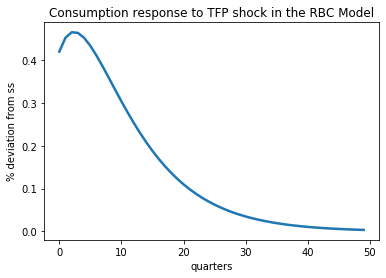

In [42]:
dOut_rbc = rbc_G[["C"]] @ {"Z": 0.01 * 0.8 ** np.arange(300)}

plt.plot(100 * dOut_rbc["C"][:50]/rbc_ss["C"], linewidth=2.5)
plt.title(r'Consumption response to TFP shock in the RBC Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

Because the `JacobianDict` defines the linearized relationship between any input path to any output path across time (in "sequence space"), it is simple to also find the response to a news shock.

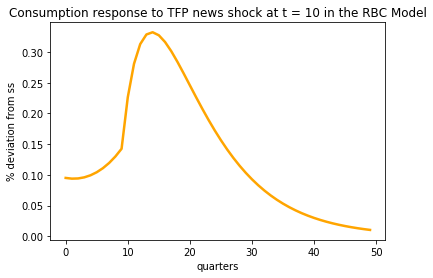

In [41]:
dOut_rbc_news = rbc_G[["C"]] @ {"Z": np.concatenate((np.zeros(10), 0.01 * 0.8 ** np.arange(290)))}

plt.plot(100 * dOut_rbc_news["C"][:50]/rbc_ss["C"], linewidth=2.5, color="orange")
plt.title(r'Consumption response to TFP news shock at t = 10 in the RBC Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

### Krusell Smith Example

We can represent this model as a simple DAG in just 1 unknown $K$ and 1 target, asset market clearing:

![Directed Acyclical Graph](../figures/ks_dag.png)

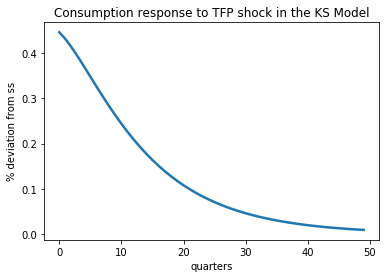

In [43]:
from sequence_jacobian.models import krusell_smith

# Use the pre-defined blocks from the model module
# We can include the definitions of the grids for income and assets as blocks as well, hence the inclusion of
# krusell_smith.income_state_vars and krusell_smith.asset_state_vars as additional SimpleBlocks
ks_blocks = [krusell_smith.household, krusell_smith.firm, krusell_smith.mkt_clearing, krusell_smith.income_state_vars,
             krusell_smith.asset_state_vars, krusell_smith.firm_steady_state_solution]

ks_calibration = {"eis": 1, "delta": 0.025, "alpha": 0.11, "rho": 0.966, "sigma": 0.5, "L": 1.0,
                  "nS": 2, "nA": 10, "amax": 200, "r": 0.01}
ks_ss_unknowns = {"beta": (0.98/1.01, 0.999/1.01)}
ks_ss_targets = {"K": "A"}
ks_ss = steady_state(ks_blocks, ks_calibration, ks_ss_unknowns, ks_ss_targets, solver="brentq")

ks_G = get_G(block_list=ks_blocks, exogenous=['Z'], unknowns=['K'], targets=['asset_mkt'], T=300, ss=ks_ss)

dOut_ks = ks_G[["C"]] @ {"Z": 0.01 * 0.8 ** np.arange(300)}

plt.plot(100 * dOut_ks["C"][:50]/ks_ss["C"], linewidth=2.5)
plt.title(r'Consumption response to TFP shock in the KS Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

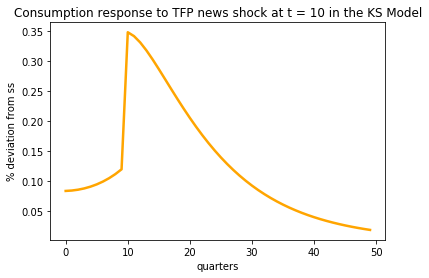

In [45]:
dOut_ks_news = ks_G[["C"]] @ {"Z": np.concatenate((np.zeros(10), 0.01 * 0.8 ** np.arange(290)))}

plt.plot(100 * dOut_ks_news["C"][:50]/ks_ss["C"], linewidth=2.5, color="orange")
plt.title(r'Consumption response to TFP news shock at t = 10 in the KS Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

### One Asset HANK Model Example

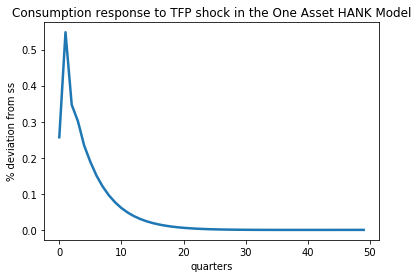

In [46]:
from sequence_jacobian.models import hank

# Use the pre-defined blocks from the model module
hank_blocks = [hank.household, hank.firm, hank.monetary, hank.fiscal, hank.mkt_clearing, hank.nkpc,
               hank.income_state_vars, hank.asset_state_vars, hank.partial_steady_state_solution]

hank_calibration = {"r": 0.005, "rstar": 0.005, "eis": 0.5, "frisch": 0.5, "mu": 1.2, "B_Y": 5.6,
                    "rho_s": 0.966, "sigma_s": 0.5, "kappa": 0.1, "phi": 1.5, "Y": 1, "Z": 1, "L": 1,
                    "pi": 0, "nS": 2, "amax": 150, "nA": 10}
hank_ss_unknowns = {"beta": 0.986, "vphi": 0.8}
hank_ss_targets = {"asset_mkt": 0, "labor_mkt": 0}
hank_ss = steady_state(hank_blocks, hank_calibration, hank_ss_unknowns, hank_ss_targets, solver="broyden_custom")

hank_G = get_G(block_list=hank_blocks, exogenous=['rstar', 'Z'], unknowns=['pi', 'w', 'Y'],
               targets=['nkpc_res', 'asset_mkt', 'labor_mkt'], T=300, ss=hank_ss)

dOut_hank = hank_G[["C"]] @ {"Z": 0.01 * 0.8 ** np.arange(300)}

plt.plot(100 * dOut_hank["C"][:50]/hank_ss["C"], linewidth=2.5)
plt.title(r'Consumption response to TFP shock in the One Asset HANK Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

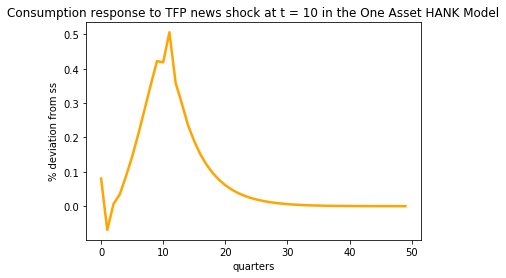

In [48]:
dOut_hank_news = hank_G[["C"]] @ {"Z": np.concatenate((np.zeros(10), 0.01 * 0.8 ** np.arange(290)))}

plt.plot(100 * dOut_hank_news["C"][:50]/hank_ss["C"], linewidth=2.5, color="orange")
plt.title(r'Consumption response to TFP news shock at t = 10 in the One Asset HANK Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

## 2.C `td_solve`

One can also use `sequence-jacobian` to solve for non-linear impulse responses of a set of endogenous variables by providing the full path of a set of shocks. This may be useful to see if the true impulse response of a set of variables actually does scale linearly, irrespective of the size, and is symmetric across sign. We will show a few comparisons of the non-linear responses with the corresponding linear responses plotted above.

### RBC Example

On iteration 0
   max error for goods_mkt is 8.91E-04
   max error for euler is 2.75E-03
On iteration 1
   max error for goods_mkt is 9.21E-05
   max error for euler is 4.07E-05
On iteration 2
   max error for goods_mkt is 4.07E-07
   max error for euler is 4.66E-07
On iteration 3
   max error for goods_mkt is 5.74E-09
   max error for euler is 5.76E-09


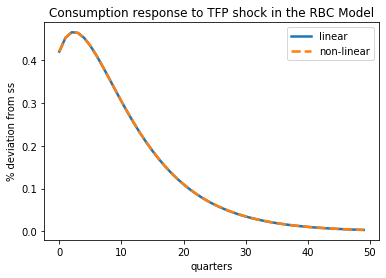

In [49]:
rbc_td = td_solve(ss=rbc_ss, block_list=rbc_blocks,
                  unknowns=['K', 'L'], targets=['goods_mkt', 'euler'],
                  Z=rbc_ss['Z'] + 0.01 * 0.8 ** np.arange(300))
dOut_rbc_nonlin = 100 * (rbc_td["C"]/rbc_ss["C"] - 1)

plt.plot(100 * dOut_rbc["C"][:50]/rbc_ss["C"], linewidth=2.5, label="linear")
plt.plot(dOut_rbc_nonlin[:50], linewidth=2.5, linestyle="--", label="non-linear")
plt.title(r'Consumption response to TFP shock in the RBC Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

### Krusell Smith Example

On iteration 0
   max error for asset_mkt is 3.43E-02
On iteration 1
   max error for asset_mkt is 1.43E-05
On iteration 2
   max error for asset_mkt is 3.68E-08
On iteration 3
   max error for asset_mkt is 7.72E-11


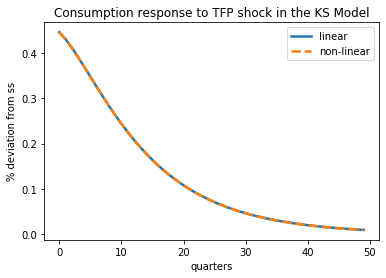

In [52]:
ks_td = td_solve(ss=ks_ss, block_list=ks_blocks,
                 unknowns=['K'], targets=['asset_mkt'],
                 Z=ks_ss['Z'] + 0.01 * 0.8 ** np.arange(300))
dOut_ks_nonlin = 100 * (ks_td["C"]/ks_ss["C"] - 1)

plt.plot(100 * dOut_ks["C"][:50]/ks_ss["C"], linewidth=2.5, label="linear")
plt.plot(dOut_ks_nonlin[:50], linewidth=2.5, linestyle="--", label="non-linear")
plt.title(r'Consumption response to TFP shock in the KS Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

### One Asset HANK Example

On iteration 0
   max error for nkpc_res is 8.25E-04
   max error for asset_mkt is 2.19E-02
   max error for labor_mkt is 8.55E-03
On iteration 1
   max error for nkpc_res is 2.29E-06
   max error for asset_mkt is 4.13E-04
   max error for labor_mkt is 8.89E-05
On iteration 2
   max error for nkpc_res is 1.29E-08
   max error for asset_mkt is 1.30E-05
   max error for labor_mkt is 9.45E-07
On iteration 3
   max error for nkpc_res is 3.04E-09
   max error for asset_mkt is 4.51E-07
   max error for labor_mkt is 3.11E-08
On iteration 4
   max error for nkpc_res is 1.11E-10
   max error for asset_mkt is 1.48E-08
   max error for labor_mkt is 1.68E-09
On iteration 5
   max error for nkpc_res is 3.46E-12
   max error for asset_mkt is 4.23E-10
   max error for labor_mkt is 6.60E-11


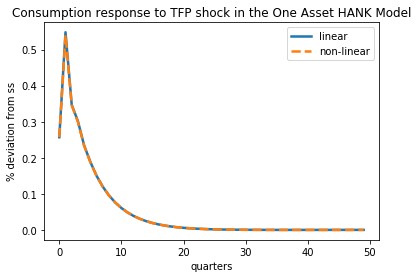

In [54]:
hank_td = td_solve(ss=hank_ss, block_list=hank_blocks,
                   unknowns=['pi', 'w', 'Y'], targets=['nkpc_res', 'asset_mkt', 'labor_mkt'],
                   Z=hank_ss['Z'] + 0.01 * 0.8 ** np.arange(300))
dOut_hank_nonlin = 100 * (hank_td["C"]/hank_ss["C"] - 1)

plt.plot(100 * dOut_hank["C"][:50]/hank_ss["C"], linewidth=2.5, label="linear")
plt.plot(dOut_hank_nonlin[:50], linewidth=2.5, linestyle="--", label="non-linear")
plt.title(r'Consumption response to TFP shock in the One Asset HANK Model')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()